# Urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background
This notebook addressess the calculation of land consumption rate (urbanization) using **Normalized Differential Built Index (NDBI)** and  **Normalized Differential Vegetation Index (NDVI)**. 
This notebook makes use of **Dask** for parrallel processing and **Geomedian composites** in combining and procesing of the landsat images for the two different years. Also the calculate band indicies function was used in calculating the **NDBI, NDVI, BI**.


## Description
This notebook demonstrates how to:

1. Enabling Dask and the Dask Dashboard.
2. Loading data with Dask in chunks.
3. Generate the Geomedian composite for the two different years.
4. Calculate urbanization indices using the Calculate Band Indices function.
5. Plotting a histogram of the two year for the built up areas.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
from odc.algo import to_f32, from_float, xr_geomedian

import sys
sys.path.append('../Scripts')

import warnings
warnings.filterwarnings("ignore")

from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [2]:
dc = datacube.Datacube(app='DEA_urbanization')

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44961 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [4]:
#Alter the lat and lon to suit your stude area
lat, lon = 6.6724, -1.6070

#Provide your area of extent here
buffer = 0.1

#Change the years values also here
#Note: landsat 8 starts from 2013
first_year = 2015
second_year = 2018

In [5]:
# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15)
}

In [6]:
#Display area of interest
display_map(query['x'], query['y'], zoom_bias = 1)

In [7]:
#Determine the most common used CRS for the product
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

In [8]:
#this function calculate the products using dash for quick loading 
def compute_ds(query, output_crs):
    try:
        ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              output_crs=output_crs,
              progress_cbk= with_ui_cbk(),
              dask_chunks={'time': 1, 'x': 500, 'y': 500},
              **query)
        return ds
    except ValueError:
        print('No Data Available')
    
    

In [9]:
query['time'] = first_year
ds_year_one = compute_ds(query, output_crs)

query['time'] = second_year
ds_year_two = compute_ds(query, output_crs)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 36 time steps as a dask array


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 69 time steps as a dask array


In [10]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

In [11]:
def generate_geomedian(ds_dataset):
    
    #scale the values using the f_32 util function
    ds_scaled = to_f32(ds_dataset, scale=scale, offset=offset)

    #generate a geomedian
    ds_geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                         nocheck=True)   # disable checks inside library that use too much ram
    #convert SR scaling values back to original values
    ds_geomedian = from_float(ds_geomedian, 
                           dtype='float32', 
                           nodata=np.nan, 
                           scale=1/scale, 
                           offset=-offset/scale)
   
    ds_geomedian = ds_geomedian.compute()

    return ds_geomedian



In [12]:
%%time
ds_year_one_geomedian = generate_geomedian(ds_year_one)
ds_year_two_geomedian = generate_geomedian(ds_year_two)

CPU times: user 15.9 s, sys: 1.1 s, total: 17 s
Wall time: 5min 6s


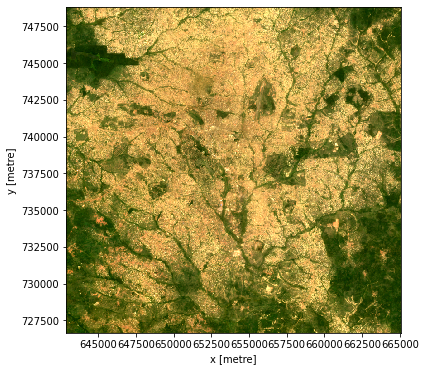

In [13]:
rgb(ds_year_one_geomedian)

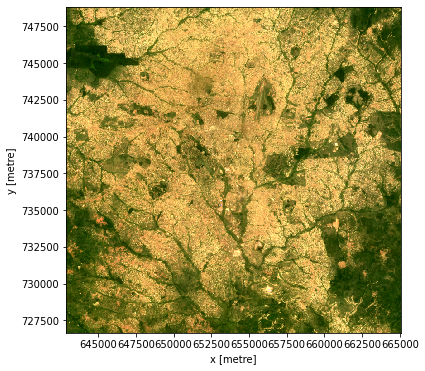

In [14]:
rgb(ds_year_two_geomedian)

In [15]:
# Calculate NDVI and NDBI using the formula above
ds_year_one_geomedian = calculate_indices(ds_year_one_geomedian, index=['NDVI', 'NDBI', 'BUI', 'BSI'], collection = 'c1')
ds_year_two_geomedian = calculate_indices(ds_year_two_geomedian, index=['NDVI', 'NDBI', 'BUI', 'BSI'], collection = 'c1')

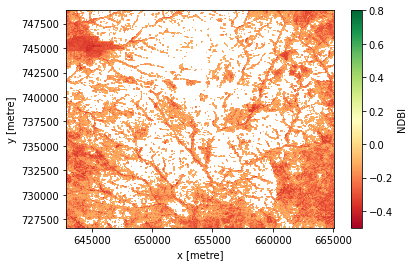

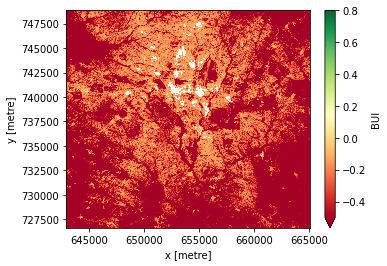

In [16]:
# Plot the results for one time step to see what they look like:
# ds_indices.NDVI.isel(time=0).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
ds_year_one_geomedian.NDBI.where(ds_year_one_geomedian.NDBI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
ds_year_one_geomedian.BUI.where(ds_year_one_geomedian.BUI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

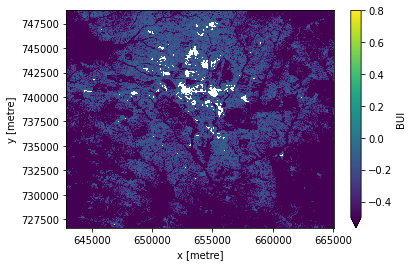

In [17]:
ds_year_one_geomedian.BUI.where(ds_year_one_geomedian.BUI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='viridis')

In [18]:
ds_year_one_geomedian['built_index'] = ds_year_one_geomedian.BUI - ds_year_one_geomedian.NDVI
ds_year_two_geomedian['built_index'] = ds_year_two_geomedian.BUI - ds_year_two_geomedian.NDVI

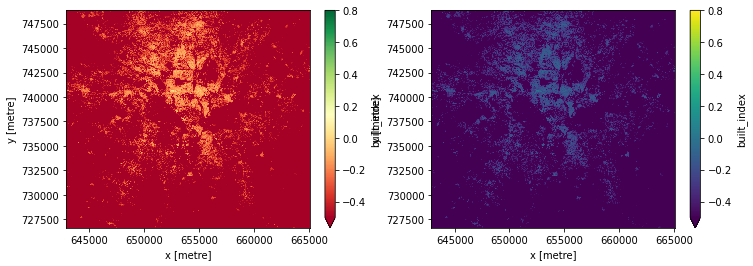

In [19]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
ds_year_one_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
fig.add_subplot(122)
ds_year_two_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='viridis')

In [20]:
#filter to get only the 
year_one_urban_area = ds_year_one_geomedian.where(ds_year_one_geomedian.built_index < -0.1)
year_two_urban_area = ds_year_two_geomedian.where(ds_year_two_geomedian.built_index < -0.1)

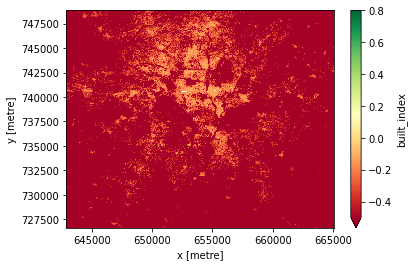

In [21]:
year_one_urban_area.built_index.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

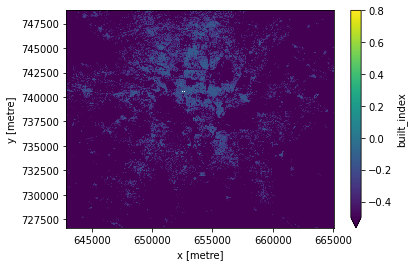

In [22]:
year_two_urban_area.built_index.plot(vmin=-0.50, vmax=0.8, cmap='viridis')

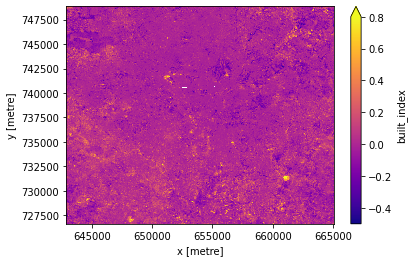

In [23]:
change_urban = year_two_urban_area - year_one_urban_area
change_urban.built_index.plot(vmin=-0.50, vmax=0.8, cmap='plasma')

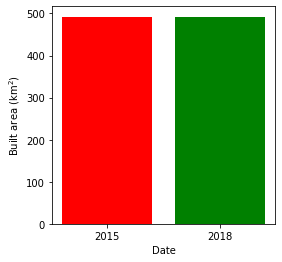

491.8302


In [24]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2
builtarea_one = year_one_urban_area.built_index.count(dim=['x','y']) * area_per_pixel
builtarea_two = year_two_urban_area.built_index.count(dim=['x','y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], [builtarea_one, builtarea_two], tick_label = [first_year, second_year], width = 0.8, color = ['red', 'green'])
axes.set_xlabel("Date")
axes.set_ylabel("Built area (km$^2$)")
plt.show()

change_urban = change_urban.built_index.count(dim=['x','y']) * area_per_pixel
print(change_urban.values)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)